In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import tensorflow_datasets as tfds
from torch.utils.data import TensorDataset
import tensorflow as tf
from torch.utils.data import random_split

c:\Program Files\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data, val_data, test_data = tfds.load(name="CatsVsDogs", as_supervised=True, split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

In [3]:
labels = {0:"Cat", 1:"Dog"}

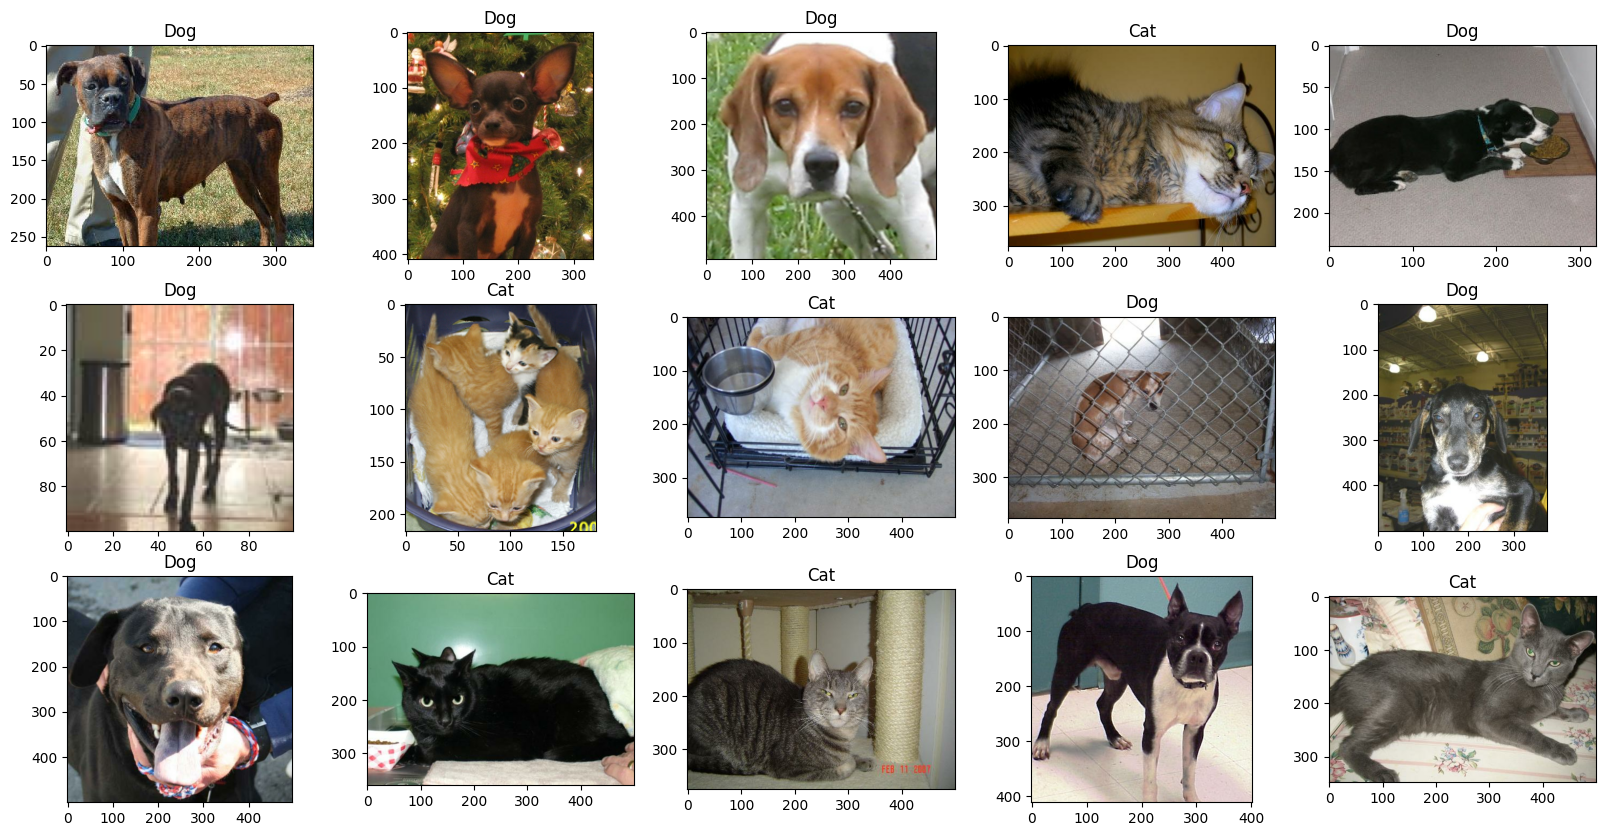

In [4]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for (i, (X, y)), ax in zip(enumerate(data), axes.ravel()):
  ax.imshow(X)
  ax.set_title(labels[int(y)])
  if i == 14:
    break

36 365.0491671144546 500
50 410.3565824825363 500


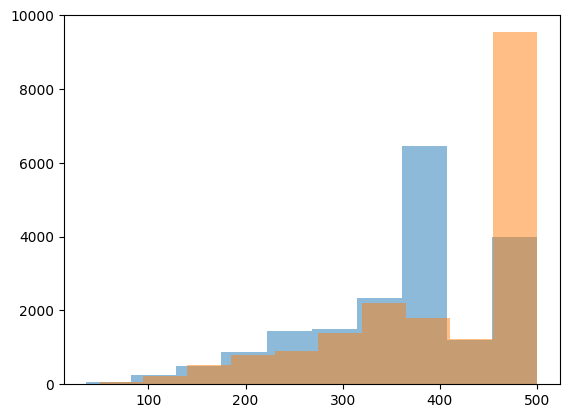

In [28]:
shapes = np.array([[0, 0]])
for X, y in data:
  shapes = np.concatenate((shapes, np.array(X.shape[:2]).reshape(1, 2)))

shapes = shapes[1:, :]

print(np.min(shapes[:, 0]), np.mean(shapes[:, 0]), np.max(shapes[:, 0]))
print(np.min(shapes[:, 1]), np.mean(shapes[:, 1]), np.max(shapes[:, 1]))

plt.hist(shapes[:, 0], alpha=0.5);
plt.hist(shapes[:, 1], alpha=0.5);

In [5]:
def transform_images(X, y):
  X = tf.image.resize(X, (365, 410)) / 255
  return X, y

In [6]:
data = data.map(transform_images)
val_data = val_data.map(transform_images)
test_data = test_data.map(transform_images)

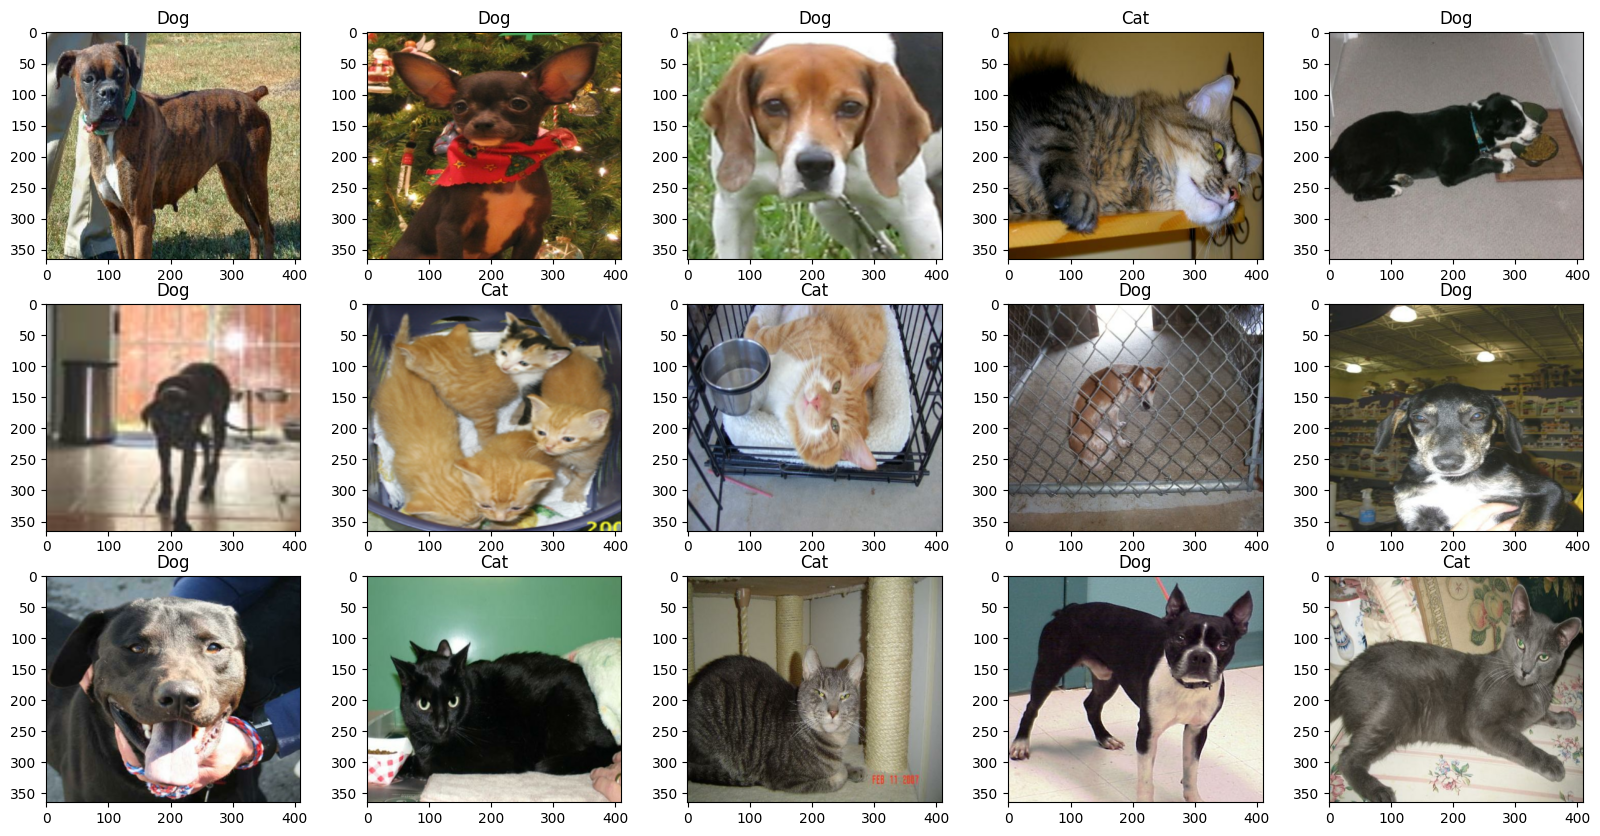

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for (i, (X, y)), ax in zip(enumerate(data), axes.ravel()):
  ax.imshow(X)
  ax.set_title(labels[int(y)])
  if i == 14:
    break

In [40]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
        #32
        nn.Conv2d(3, 32, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        #64
        nn.Conv2d(32, 64, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        #128
        nn.Conv2d(64, 128, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        #Linear
        nn.Flatten(),
        nn.Linear(269696, 100),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

  def forward(self, X):
    return self.seq(X)

In [16]:
def evaluate(data, model, batch_size):
  model.eval()
  accurate_predictions = 0
  predictions = 0
  for X, y in data.batch(batch_size):
    X = torch.tensor(np.array(X).reshape(len(X), 3, 365, 410))
    y = torch.tensor(np.array(y).reshape(-1, 1)).to(torch.float32)
    pred = np.where(np.array(model(X).detach()) > 0.5, 1, 0)
    accurate_predictions += np.sum(pred == np.array(y))
    predictions += len(X)
  return round(accurate_predictions / predictions * 100, 3)

In [17]:
def train(train_data, val_data, model, loss_fn, optimizer, batch_size, epoch):
  model.train()
  for X, y in train_data.batch(batch_size):
    X = torch.tensor(np.array(X).reshape(len(X), 3, 365, 410))
    y = torch.tensor(np.array(y).reshape(-1, 1)).to(torch.float32)
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  train_accuracy = evaluate(train_data, model, batch_size)
  val_accuracy = evaluate(val_data, model, batch_size)
  print(f"Epoch: {epoch} Train accuracy: {train_accuracy}% Validation accuracy: {val_accuracy}%")


In [41]:
model = NeuralNetwork()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [42]:
for i in range(10):
  train(data, val_data, model, loss_fn, optimizer, 10, i + 1)

Epoch: 1 Train accuracy: 50.892% Validation accuracy: 52.88%
Epoch: 2 Train accuracy: 56.459% Validation accuracy: 56.707%
Epoch: 3 Train accuracy: 56.808% Validation accuracy: 57.782%
Epoch: 4 Train accuracy: 60.956% Validation accuracy: 60.189%
Epoch: 5 Train accuracy: 59.742% Validation accuracy: 58.942%
Epoch: 6 Train accuracy: 60.962% Validation accuracy: 62.855%
Epoch: 7 Train accuracy: 62.16% Validation accuracy: 60.791%
Epoch: 8 Train accuracy: 59.715% Validation accuracy: 56.406%
Epoch: 9 Train accuracy: 65.433% Validation accuracy: 62.683%
Epoch: 10 Train accuracy: 65.723% Validation accuracy: 61.78%


In [43]:
for i in range(5):
  train(data, val_data, model, loss_fn, optimizer, 10, i + 11)

Epoch: 11 Train accuracy: 66.566% Validation accuracy: 62.339%
Epoch: 12 Train accuracy: 70.962% Validation accuracy: 64.746%
Epoch: 13 Train accuracy: 70.344% Validation accuracy: 62.597%
Epoch: 14 Train accuracy: 72.445% Validation accuracy: 61.565%
Epoch: 15 Train accuracy: 77.227% Validation accuracy: 61.522%


In [44]:
for i in range(5):
  train(data, val_data, model, loss_fn, optimizer, 10, i + 16)

Epoch: 16 Train accuracy: 77.415% Validation accuracy: 61.608%
Epoch: 17 Train accuracy: 78.033% Validation accuracy: 60.146%
Epoch: 18 Train accuracy: 83.778% Validation accuracy: 62.64%
Epoch: 19 Train accuracy: 84.32% Validation accuracy: 62.597%
Epoch: 20 Train accuracy: 86.738% Validation accuracy: 61.393%


It overfits, so I will need to optimize it more